In [1]:
%reset
import numpy as np
import pandas as pd
from osgeo import gdal, osr, ogr
from skimage import exposure
from skimage.segmentation import quickshift, slic
from sklearn.ensemble import RandomForestClassifier
import time
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle

## Based on Tutorial from https://opensourceoptions.com/blog/python-geographic-object-based-image-analysis-geobia/

#naip_fn = "D:/cbr/VP2/CodeOutput/output_file_mspec.tif"
naip_fn = "D:/cbr/VP2/VP2_SoilMapping/CodeOutput/channelFusion_Wetzwil_test.tif"

print(naip_fn)
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)

nbands = naip_ds.RasterCount
band_data = []

print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
        band = naip_ds.GetRasterBand(i).ReadAsArray()
        band_data.append(band)

band_data = np.dstack(band_data)
print(band_data.shape)



D:/cbr/VP2/VP2_SoilMapping/CodeOutput/channelFusion_Wetzwil_test.tif
bands 7 rows 8552 columns 10633
(8552, 10633, 7)


In [2]:
# scale image values from 0.0 - 1.0
#band_data[np.isnan(band_data)] = 0
band_data[np.isnan(band_data)] = -9999.0
img = exposure.rescale_intensity(band_data, in_range= (0.0, 225))

# do segmentation multiple options with quickshift and slic
seg_start = time.time()
#segments = quickshift(img, ratio=0.8, convert2lab=False)
# segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
segments = slic(img, n_segments=1000, compactness=3, start_label = 1, multichannel="TRUE", convert2lab=False)
print('segments complete', time.time() - seg_start)

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            band_stats[3] = 0.0
        features += band_stats
    return features

segments complete 201.48933911323547


In [3]:
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

In [4]:

train_fn = "D:/cbr/VP2/VP2_SoilMapping/Shapes/train2.shp"
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

classes = np.unique(ground_truth)[1:]
print('class values', classes)

segments_per_class = {}
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segment for class", klass, ":", len(segments_of_class))

intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments

assert len(intersection) == 0, "Segments represent multiple classes"

    


min 0 max 2 mean 1.0337234004274072e-06
class values [1 2]
Training segment for class 1 : 58
Training segment for class 2 : 18


In [6]:
train_img = np.copy(segments)
threshold = train_img.max() + 1

for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

training_objects = []
training_labels = []

for klass in classes:
    class_train_object = [v for i,v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] *len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

classifier = RandomForestClassifier(n_jobs=1)
classifier.fit(training_objects, training_labels)
importance = classifier.feature_importances_

#feature_names = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
#std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
#forest_importances = pd.Series(importance, index=feature_names)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

filename = 'classifier_prediction_model.sav'
pickle.dump(classifier, open(filename, 'wb'))
print('Fitting Random Forest Classifier')
predicted = classifier.predict(objects)
print('Predicting Classification')

clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass

print('Prediction applied to numpy array')

mask = np.sum(img, axis=2)
mask[mask> 0] = 1.0
mask[mask == 0] = -1.0

clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

print('Saving classification to raster')
def CreateGeoTiff(Name, Array, driver, GeoT, Projection, DataType):
    DataSet = driver.Create(Name, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection)
    DataSet.GetRasterBand(1).SetNoDataValue(-9999.0)
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet.FlushCache()
    return Name

CreateGeoTiff('D:/cbr/VP2/VP2_SoilMapping/Processed/classified_Wetzwil_mitDEM.tif', clf, gdal.GetDriverByName ( "GTiff" ), naip_ds.GetGeoTransform(), naip_ds.GetProjection(), gdal.GDT_Float32)
print('Done')

    

Training objects for class 1 : 56
Training objects for class 2 : 15
Fitting Random Forest Classifier
Predicting Classification
Prediction applied to numpy array
Saving classification to raster
Done


C:\Users\st1154414\.conda\envs\pygdal\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (90933416 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\st1154414\.conda\envs\pygdal\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (90914232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

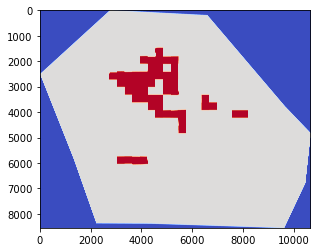

In [12]:
import matplotlib as mp
import matplotlib.pyplot as plt




img2=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/classified_Wetzwil_mitDEM.tif')
img=plt.imread('D:/cbr/VP2/VP2_SoilMapping/Processed/classified_Wetzwil_gross.tif')


fig, ax = plt.subplots(1, 2, figsize=(17,12))
    ax[0].imshow(img2[:, :, 0], cmap=plt.cm.coolwarm))
    ax[1].imshow(img[:, :, 0], cmap=plt.cm.coolwarm)


fig, ax = plt.subplots()

ax.imshow(img2[:, :, 0], cmap=plt.cm.coolwarm)
plt.show